In [62]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRFRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from featurewiz import featurewiz
from sklearn.linear_model import LinearRegression



# Functions


In [63]:
df = pd.read_csv("..\\7. Data Preparation\\Basic_information_cleaned5.csv", index_col=0)

In [64]:
# open macroeconomic data
df_macro = pd.read_csv("..\\6. Macroeconomic Data\\Macro.csv",sep=";", index_col=0)

In [65]:
def get_fcf_val(current_earnings,growth_1,growth_2, discount_rate, exit_multiple):
    year1 = (current_earnings * (1 + growth_1))
    year2 = (year1 * (1 + growth_1))
    year3 = (year2 * (1 + growth_1))
    year4 = (year3 * (1 + growth_1))
    year5 = (year4 * (1 + growth_1))
    year6 = (year5 * (1 + growth_2))
    year7 = (year6 * (1 + growth_2))
    year8 = (year7 * (1 + growth_2))
    year9 = (year8 * (1 + growth_2))
    year10 = (year9 * (1 + growth_2))

    discounted_year1 = year1 / (1 + discount_rate)
    discounted_year2 = year2 / (1 + discount_rate)**2
    discounted_year3 = year3 / (1 + discount_rate)**3
    discounted_year4 = year4 / (1 + discount_rate)**4
    discounted_year5 = year5 / (1 + discount_rate)**5
    discounted_year6 = year6 / (1 + discount_rate)**6
    discounted_year7 = year7 / (1 + discount_rate)**7
    discounted_year8 = year8 / (1 + discount_rate)**8
    discounted_year9 = year9 / (1 + discount_rate)**9
    discounted_year10 = year10 / (1 + discount_rate)**10

    discounted_values = [discounted_year1, discounted_year2, discounted_year3, discounted_year4, discounted_year5, discounted_year6, discounted_year7, discounted_year8, discounted_year9, discounted_year10]

    exit_value = (year10 * exit_multiple) / (1 + discount_rate)**10

    dcf = pd.DataFrame({"Discounted Value": discounted_values}, index=["Year 1", "Year 2", "Year 3", "Year 4", "Year 5", "Year 6", "Year 7", "Year 8", "Year 9", "Year 10"])
    dcf["Cumulative Value"] = dcf["Discounted Value"].cumsum()

    present_value = dcf.at["Year 9","Cumulative Value"] + exit_value
    return present_value.round(2)

In [66]:
def calculate_valuation_metrics(fundamental_data):
    # fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\"+ticker+".csv", index_col=0)

    # calculamos el per histórico
    fundamental_data["PER"] = fundamental_data["Close"].shift(1) / fundamental_data["EPS"]
    fundamental_data["PER_3"] = fundamental_data["PER"].rolling(3).mean()
    fundamental_data["PER_5"] = fundamental_data["PER"].rolling(5).mean()
    fundamental_data["PER_10"] = fundamental_data["PER"].rolling(10).mean()

    fundamental_data["Intrinsic Value"] = fundamental_data["EPS"] * fundamental_data["PER"]
    fundamental_data["Intrinsic Value 3"] = fundamental_data["EPS"] * fundamental_data["PER_3"]
    fundamental_data["Intrinsic Value 5"] = fundamental_data["EPS"] * fundamental_data["PER_5"]
    fundamental_data["Intrinsic Value 10"] = fundamental_data["EPS"] * fundamental_data["PER_10"]

    fundamental_data["Intrinsic Value FCF"] = 0
    
    for index, row in fundamental_data.iterrows():
        # Discounted Cash Flow
        fundamental_data.loc[index,"Intrinsic Value FCF"] = get_fcf_val(row["EPS"], row["EPS Diluted growth 3 year average"] *0.8, row["EPS Diluted growth 5 year average"] *0.5, 0.14, row["PER_5"])
    
    # replace np.inf with 0
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].replace(np.inf, np.nan)
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].replace(-np.inf, np.nan)
    # replace nan or zero values
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value 10"])
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value 5"])
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value 3"])
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value"])
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Close"])

    # calculate price moving average not including the current year
    fundamental_data["Price Moving Average 2 years"] = fundamental_data["Close"].shift(1).rolling(2).mean()
    fundamental_data["Price Moving Average 3 years"] = fundamental_data["Close"].shift(1).rolling(3).mean()
    fundamental_data["Price Moving Average 4 years"] = fundamental_data["Close"].shift(1).rolling(4).mean()
    fundamental_data["Price Moving Average 5 years"] = fundamental_data["Close"].shift(1).rolling(5).mean()
    fundamental_data["Price Moving Average 6 years"] = fundamental_data["Close"].shift(1).rolling(6).mean()
    fundamental_data["Price Moving Average 7 years"] = fundamental_data["Close"].shift(1).rolling(7).mean()
    fundamental_data["Price Moving Average 8 years"] = fundamental_data["Close"].shift(1).rolling(8).mean()
    fundamental_data["Price Moving Average 9 years"] = fundamental_data["Close"].shift(1).rolling(9).mean()
    fundamental_data["Price Moving Average 10 years"] = fundamental_data["Close"].shift(1).rolling(10).mean()

    # # Create MACD
    # fundamental_data['2ema'] = fundamental_data['Close'].shift(1).ewma(span=2)
    # fundamental_data['1ema'] = fundamental_data['Close'].shift(1).ewma(span=1)
    # fundamental_data['MACD'] = (fundamental_data['1ema']-fundamental_data['2ema'])

    # # Create Bollinger Bands
    # fundamental_data['20sd'] = fundamental_data['Close'].shift(1).stats.moments.rolling_std(20)
    # fundamental_data['upper_band'] = fundamental_data['ma21'] + (fundamental_data['20sd']*2)
    # fundamental_data['lower_band'] = fundamental_data['ma21'] - (fundamental_data['20sd']*2)
    
    # # Create Exponential moving average
    # fundamental_data['ema'] = fundamental_data['Close'].shift(1).ewm(com=0.5).mean()
    
    # Create Momentum
    # fundamental_data['momentum'] = fundamental_data['Close'].shift(1)-1

    # # Shifted close
    # fundamental_data['shifted_close'] = fundamental_data['Close'].shift(1)

    # # Market Cap
    # # fundamental_data['Market Cap'] = fundamental_data["shifted_close"] * fundamental_data["Weighted Average Shares Outstanding"]

    # # Date
    # fundamental_data['Date'] = fundamental_data.index


    return fundamental_data

# Prediction

In [67]:
stock = "AAPL"
fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\"+stock+".csv", index_col=0)
# stock_data = calculate_valuation_metrics(fundamental_data)
# dropeamos macro
# df_macro.dropna(inplace=True)

# join the data
# stock_data = stock_data.join(df_macro)
# stock_data.replace([np.nan,np.inf, -np.inf], 0, inplace=True)

In [68]:
selected_features = ["Close","Revenue", "EPS", "EPS Diluted growth 3 year average", "EPS Diluted growth 5 year average", "EPS Diluted growth 10 year average", "Total Assets", "Dividends Paid"]

In [69]:
X = fundamental_data[selected_features]
X = calculate_valuation_metrics(X)
X.replace([np.nan,np.inf, -np.inf], 0, inplace=True)
y = fundamental_data["Close"]
# list = [col for col in stock_data.columns if "Dividend Cum" in col or "Close" in col or "Open" in col or "Volume" in col or "Price" in col]
# X = stock_data.drop(list, axis=1)


y_train = y[:round(y.shape[0]*0.7)]
y_test = y[round(y.shape[0]*0.7):]

In [70]:
# plt.rcParams['figure.figsize'] = (10, 6)
# stock_data[["Close","Intrinsic Value FCF"]].plot()

# PCA

In [71]:
# X_scaled = StandardScaler().fit_transform(X)
# X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
# X_train = X[:round(X.shape[0]*0.7)]
# X_test = X[round(X.shape[0]*0.7):]

In [72]:
# X_normalized = Normalizer().fit_transform(X)
# X = pd.DataFrame(X_normalized, index=X.index, columns=X.columns)

In [73]:
# pca = PCA(n_components=0.99)
# X_pca = pca.fit_transform(X)
# X = pd.DataFrame(X_pca, index=X.index)

In [74]:
# features = featurewiz(
#     #Set the dataset you want to do the feature selection
#     dataname= X,
#     #Set the target column
#     target = 'Close',
#     #Set threshold for removing variables, the threshold is based on   Pearson correlation
#     corr_limit=0.7
#     )


In [75]:
# X = X[features[0]]

In [76]:

# Test and train data
X_train = X[:round(X.shape[0]*0.7)]
X_test = X[round(X.shape[0]*0.7):]


### ACABA PCA

In [77]:
# model = XGBRegressor()
# model.fit(X_train, y_train)


# grid_rf = {
# 'n_estimators': np.arange(1,1000,50),
# 'learning_rate': np.arange(0.1,2,0.1),
# 'max_depth': np.arange(1, 50, 1),  
# }

# rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(X_train, y_train)
# best_parameters = rscv_fit.best_params_


In [78]:

best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [79]:

# best_model = XGBRegressor(n_estimators=best_parameters.get("n_estimators"), learning_rate=best_parameters.get("best_parameters"), n_jobs=4, max_depth=best_parameters.get("max_depth"))
# best_model.fit(X_train, y_train)
# y_pred = best_model.predict(X_test)

y_pred = pd.DataFrame(y_pred, index=y_test.index)


In [80]:
r2_score(y_test, y_pred)

-1.0619882338744113

In [81]:
y_pred.join(y_test)

,0,Close
2011,7.78260,13.115
2012,7.78260,20.880
2013,7.50040,16.215
2014,7.45945,23.565
2015,7.32545,30.105
2016,7.13000,26.285
2017,7.27860,37.685
2018,7.28345,45.465
2019,7.15325,51.180
2020,7.15325,98.730


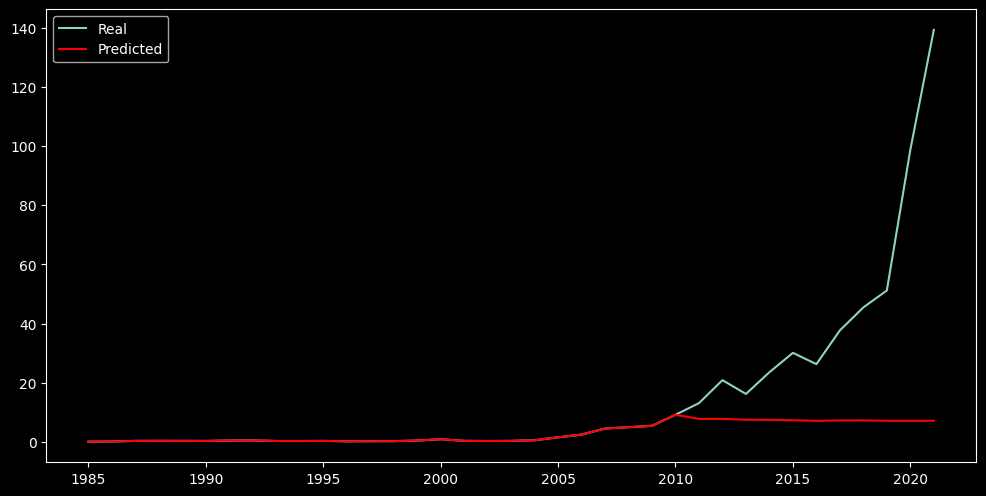

In [82]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(y, label='Real')

# concat y_train and y_pred
y_pred = pd.concat([y_train, y_pred])

plt.plot(y_pred, color='red', label='Predicted')
plt.legend()
plt.show()

# Feature Importance

In [83]:
from xgboost import plot_importance


best_model = XGBRFRegressor(n_estimators=best_parameters.get("n_estimators"), learning_rate=best_parameters.get("learning_rate"), n_jobs=4)
best_model.fit(X, y)

plt.rcParams['figure.figsize'] = (30, 15)
plot_importance(best_model)
plt.show()

NameError: name 'best_parameters' is not defined